# Exploratory Data Analysis (EDA)

This notebook explores the Sentiment140 dataset to understand its structure and prepare it for classification.

### Steps:
- Load the dataset and inspect its structure
- Adjust sentiment labels (`4 → 1`)
- Analyze the distribution of sentiment labels
- Identify missing values, duplicates, or imbalances
- Perform initial text analysis (tweet length, common words)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

## Loading the Dataset

The dataset consists of 1.6 million tweets labeled as positive or negative.  
It does not have column headers, so we need to assign appropriate names.


In [2]:
columns = ["sentiment", "id", "date", "flag", "user", "text"]

df = pd.read_csv("../data/training.1600000.processed.noemoticon.csv", 
                 encoding="latin-1", names=columns)


## Dataset Overview

The dataset contains six columns:
- `sentiment` → Target variable (0 = Negative, 4 = Positive)
- `id` → Tweet ID (not relevant)
- `date` → Timestamp of the tweet
- `flag` → Always "NO_QUERY" (not useful)
- `user` → Username of the tweet author
- `text` → Actual tweet content

Only `sentiment` and `text` are relevant for classification.


In [3]:
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.shape

(1600000, 6)

## Adjusting Sentiment Labels

The original dataset labels positive tweets as **4** and negative as **0**.  
To simplify the classification task, we change **4 → 1**, so:
- **0 = Negative**
- **1 = Positive**

In [5]:
df["sentiment"] = df["sentiment"].replace({4: 1})

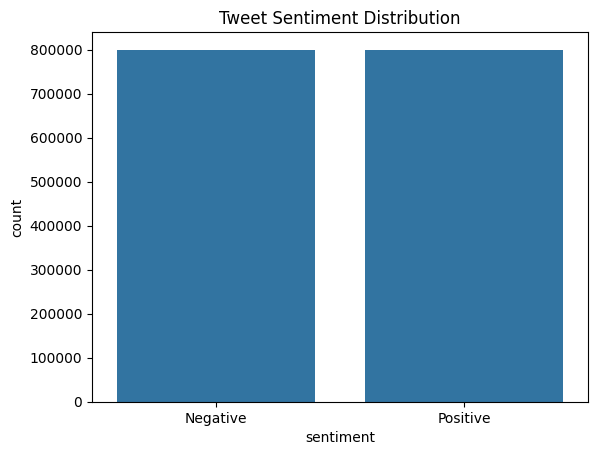

In [6]:
sns.countplot(x=df["sentiment"])
plt.title("Tweet Sentiment Distribution")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.show()


## Removing Unnecessary Columns

The dataset contains columns that are not useful for sentiment classification:
- **`id`** → A unique identifier for each tweet, not relevant for analysis.
- **`date`** → The timestamp of the tweet, does not contribute to sentiment.
- **`flag`** → Always `"NO_QUERY"`, contains no information.
- **`user`** → The username of the tweet's author, not useful for classification.

These columns are removed to keep only what is necessary:  
- **`sentiment`** → The target variable (0 = Negative, 1 = Positive)  
- **`text`** → The tweet content, which will be analyzed.



In [7]:
df["flag"].unique()

array(['NO_QUERY'], dtype=object)

In [8]:
df = df.drop(columns=["id", "date", "flag", "user"])


In [9]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Checking for Missing Values and Duplicates

Before analyzing the text, we check for missing values and duplicates.  

In [10]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [11]:
df.duplicated(subset=["text"]).sum()

np.int64(18534)

## Removing Duplicate Tweets

The dataset contains **18,534 duplicate tweets**, wich we will remove.
Duplicates can introduce bias into the model by overrepresenting certain opinions.  

In [12]:
df = df.drop_duplicates(subset=["text"])

df.shape

(1581466, 2)

## Tweet Length Analysis

Understanding tweet length distribution helps in preprocessing.  

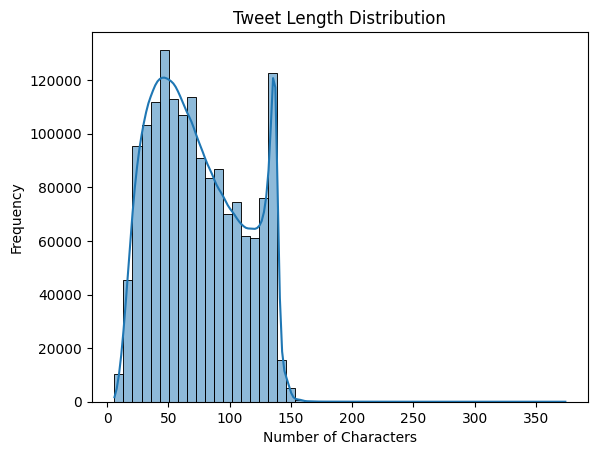

In [13]:
df["tweet_length"] = df["text"].apply(len)

sns.histplot(df["tweet_length"], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


In [14]:
avg_length = df["tweet_length"].mean()
print(f"Average tweet length: {avg_length:.2f} characters")

Average tweet length: 74.48 characters


## Most Common Words

Checking the most frequent words gives insights into the dataset's vocabulary, common stopwords should be removed.

In [15]:
nltk.download("stopwords")
stopwords = set(stopwords.words("english"))
stopwords.update(["I", "Im", "im", "u", "day", "time", "today", "going", "get", 
                  "got", "go", "one", "see", "know", "really", "back", "like", 
                  "work",  "lol", "haha", "amp", "twitter", "thats", "ill", "oh"])


# Function to clean text with improved stopword removal
def clean_text(text):
    text = text.lower() 
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) 
    text = re.sub(r"[^a-z\s]", "", text)  
    words = text.split()
    words = [word for word in words if word not in stopwords] 
    return " ".join(words)


df["clean_text"] = df["text"].apply(clean_text)


# Count word frequency
all_words = " ".join(df["clean_text"]).split()
filtered_words = [word for word in all_words if word not in stopwords]


word_freq = Counter(filtered_words)
word_freq.most_common(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('good', 88075),
 ('dont', 66754),
 ('love', 63061),
 ('cant', 62350),
 ('well', 44100),
 ('still', 42576),
 ('new', 41711),
 ('want', 41621),
 ('night', 41182),
 ('think', 40857),
 ('thanks', 39262),
 ('home', 38664),
 ('much', 36368),
 ('miss', 35642),
 ('need', 35193),
 ('last', 35050),
 ('hope', 32924),
 ('great', 32716),
 ('tomorrow', 32429),
 ('morning', 32140)]

In [16]:
# Split dataset into positive and negative tweets
positive_tweets = df[df["sentiment"] == 1]["clean_text"]
negative_tweets = df[df["sentiment"] == 0]["clean_text"]

# Count word frequencies separately
positive_words = " ".join(positive_tweets).split()
negative_words = " ".join(negative_tweets).split()

positive_freq = Counter(positive_words).most_common(20)
negative_freq = Counter(negative_words).most_common(20)

print("Most common words in positive tweets:")
print(positive_freq)

print("\nMost common words in negative tweets:")
print(negative_freq)


Most common words in positive tweets:
[('good', 59740), ('love', 46547), ('thanks', 33652), ('new', 26409), ('great', 24786), ('well', 24408), ('night', 22043), ('dont', 21968), ('happy', 19710), ('think', 19239), ('morning', 19028), ('cant', 18942), ('hope', 18583), ('fun', 17912), ('much', 16669), ('nice', 16575), ('thank', 15351), ('home', 15120), ('tomorrow', 14121), ('awesome', 13997)]

Most common words in negative tweets:
[('dont', 44786), ('cant', 43408), ('miss', 30127), ('want', 29434), ('still', 28623), ('good', 28335), ('sad', 27038), ('home', 23544), ('last', 22097), ('wish', 21923), ('need', 21917), ('think', 21618), ('feel', 21522), ('bad', 21194), ('sorry', 20064), ('didnt', 19930), ('much', 19699), ('well', 19692), ('night', 19139), ('tomorrow', 18308)]
